In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        dims = 64
        self.conv1 = nn.Conv2d(3, dims, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(dims, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net()
net.to(device)
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = lossfunc(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'\r[{epoch + 1}] loss: {loss.item():.3f}', end='')

print("\nFinished training")
torch.save(net.state_dict(), './cifar_net.pth')

cuda:0
[5] loss: 1.520
Finished training


In [35]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

In [36]:
import fairbench as fb

fb.setbackend("torch")
n_classes = len(classes)
kwargs = dict()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for cl in range(n_classes):
            ret = fb.kwargs(predictions=predicted==cl, 
                          labels=labels==cl, 
                          sensitive=fb.Fork({f"sensitive={classes[i]}": labels==i for i in range(n_classes)}))
            kwargs[cl] = fb.concatenate(kwargs.get(cl, None), ret)

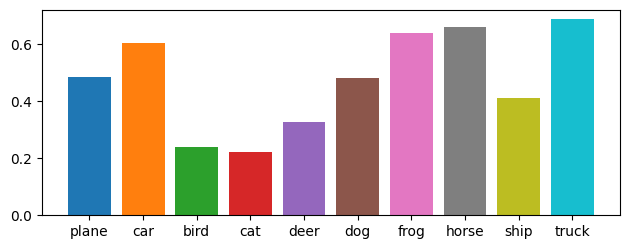

In [39]:
report = fb.combine(*[fb.reduce(fb.accuracy(**kwargs[i]), fb.min, name=classes[i]) for i in range(n_classes)])

fb.visualize(report)

In [31]:
report.bird.explain

sensitive=deer,0.958
sensitive=frog,0.981
sensitive=dog,0.956
sensitive=car,0.969
sensitive=horse,0.965
sensitive=bird,0.06299999999999994
sensitive=truck,0.977
sensitive=plane,0.986
sensitive=ship,0.988
sensitive=cat,0.946
